# The Nature Conservancy Fisheries Monitoring - SCUS 
<pre>
mode:  scus - alb, layer1, closest samples
arch:  resnet50
seed:  0
</pre>

In [1]:
import platform
import random
import torch
import torchvision
import fastai
from fastai.vision.all import *
import albumentations
from albumentations import (
    Compose,GaussianBlur,HorizontalFlip,MedianBlur,MotionBlur,OneOf,
    RandomBrightness,RandomContrast,Resize,ShiftScaleRotate,VerticalFlip
)
import cv2
import sklearn
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

print('python version:       {}'.format(platform.python_version()))
print('torch version:        {}'.format(torch.__version__))
print('torchvision version:  {}'.format(torchvision.__version__))
print('fastai version:       {}'.format(fastai.__version__))
print('albumination version: {}'.format(albumentations.__version__))
print('opencv version:       {}'.format(cv2.__version__))
print('sklearn version:      {}'.format(sklearn.__version__))
print('pandas version:       {}'.format(pd.__version__))
print('numpy version:        {}'.format(np.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:       {}'.format(use_cuda))
print('cuDNN enabled:        {}'.format(torch.backends.cudnn.enabled))
print('num gpus:             {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                  {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:       3.7.10
torch version:        1.7.0
torchvision version:  0.8.1
fastai version:       2.3.0
albumination version: 0.5.2
opencv version:       4.5.1
sklearn version:      0.24.1
pandas version:       1.1.5
numpy version:        1.19.5
CUDA available:       True
cuDNN enabled:        True
num gpus:             1
gpu:                  Tesla P100-PCIE-16GB

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [2]:
seed = 0

data_dir = Path('./train')

## Load Data from Kaggle

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer1_farthest_resnet50_s0.csv
/kaggle/input/fmacusds/fm_train_df_undersamp_alb_layer1_closest_resnet50_s0.csv
/kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z
/kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip
/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg1.csv.zip


In [4]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/train.zip .
!unzip train.zip
!rm train/.DS_Store

Archive:  train.zip
   creating: train/
  inflating: train/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/ALB/
  inflating: train/ALB/img_00003.jpg  
  inflating: train/ALB/img_00010.jpg  
  inflating: train/ALB/img_00012.jpg  
  inflating: train/ALB/img_00015.jpg  
  inflating: train/ALB/img_00019.jpg  
  inflating: train/ALB/img_00020.jpg  
  inflating: train/ALB/img_00029.jpg  
  inflating: train/ALB/img_00032.jpg  
  inflating: train/ALB/img_00037.jpg  
  inflating: train/ALB/img_00038.jpg  
  inflating: train/ALB/img_00039.jpg  
  inflating: train/ALB/img_00041.jpg  
  inflating: train/ALB/img_00043.jpg  
  inflating: train/ALB/img_00045.jpg  
  inflating: train/ALB/img_00055.jpg  
  inflating: train/ALB/img_00057.jpg  
  inflating: train/ALB/img_00074.jpg  
  inflating: train/ALB/img_00085.jpg  
  inflating: train/ALB/img_00090.jpg  
  inflating: train/ALB/img_00097.jpg  
  inflating: train/ALB/i

In [5]:
# Create DataFrame from Dataset
df_data = []
labels = []
for c in data_dir.iterdir():
    labels.append(c.name)
    for f in c.iterdir():
        df_entry = [c.name + '/' + f.name, c.name]
        df_data.append(df_entry)
        
train_df = pd.DataFrame(df_data, columns=['image','label'])
print('Labels: {}'.format(labels)); print(); train_df

Labels: ['NoF', 'YFT', 'OTHER', 'ALB', 'BET', 'DOL', 'LAG', 'SHARK']



,image,label
0,NoF/img_03757.jpg,NoF
1,NoF/img_05594.jpg,NoF
2,NoF/img_02015.jpg,NoF
3,NoF/img_07544.jpg,NoF
4,NoF/img_05928.jpg,NoF
...,...,...
3772,SHARK/img_05231.jpg,SHARK
3773,SHARK/img_07484.jpg,SHARK
3774,SHARK/img_06786.jpg,SHARK
3775,SHARK/img_06677.jpg,SHARK


## Undersampling

In [6]:
alb_train_df = pd.read_csv('../input/fmacusds/fm_train_df_undersamp_alb_layer1_closest_resnet50_s0.csv')

train_df = pd.concat(
    [train_df.query('label == "YFT"')] +
    [train_df.query('label == "NoF"')] +
    [train_df.query('label == "OTHER"')] +
    [train_df.query('label == "BET"')] +
    [train_df.query('label == "SHARK"')] +
    [train_df.query('label == "DOL"')] +
    [train_df.query('label == "LAG"')] +
    [alb_train_df]
).sample(frac=1.0, random_state=seed).reset_index(drop=True)

print('Samples: {}'.format(train_df.shape[0]))
train_df.head()

Samples: 2792


,image,label
0,BET/img_02757.jpg,BET
1,ALB/img_03369.jpg,ALB
2,YFT/img_03065.jpg,YFT
3,BET/img_01166.jpg,BET
4,SHARK/img_05464.jpg,SHARK


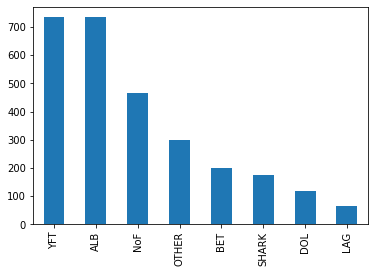

In [8]:
# Plot Sample Counts per Class
train_df['label'].value_counts().plot(kind='bar');

In [9]:
df = pd.DataFrame({
    'train': train_df['label'].value_counts()
})

df["train_pct"] = df["train"]/df["train"].sum(); df

,train,train_pct
YFT,734,0.262894
ALB,734,0.262894
NoF,465,0.166547
OTHER,299,0.107092
BET,200,0.071633
SHARK,176,0.063037
DOL,117,0.041905
LAG,67,0.023997


In [10]:
# Save Data Df
train_df.to_csv('fm_train_df_acus_layer1_c_resnet50_s0.csv', index=False)

## Load Data into Fastai DataLoader

In [11]:
# Define Data Augmentation Functions
# similar to: https://isaac-flath.github.io/fastblog/computer%20vision/image%20classification/kaggle/2021/02/15/PlantPathologyKaggle.html
# but without vertical flip (since the image is not from above)

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order = None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)
    
    
def get_train_aug(image_size): 
    return Compose([
        Resize(height=image_size[0], width=image_size[1]),
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
    ])


def get_valid_aug(image_size): 
    return  Compose([
        Resize(height=image_size[0], width=image_size[1]),
    ])

In [12]:
# Load Data into Fastai DataLoader and Add Data Augmentation Functions
set_seed(seed, reproducible=True)

image_size = [224,244]
item_tfms  = [AlbumentationsTransform(get_train_aug(image_size), get_valid_aug(image_size))]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    getters=[ColReader('image', pref=data_dir), ColReader('label')], 
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = db.dataloaders(source=train_df, bs=25, seed=seed)

print('Classes: {}'.format(dls.vocab)); print()
print('Train Samples: {}'.format(len(dls.train_ds)))
print('Valid Samples: {}'.format(len(dls.valid_ds)))
print('Total Samples: {}'.format(len(dls.train_ds) + len(dls.valid_ds)))

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


Classes: ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Train Samples: 2234
Valid Samples: 558
Total Samples: 2792


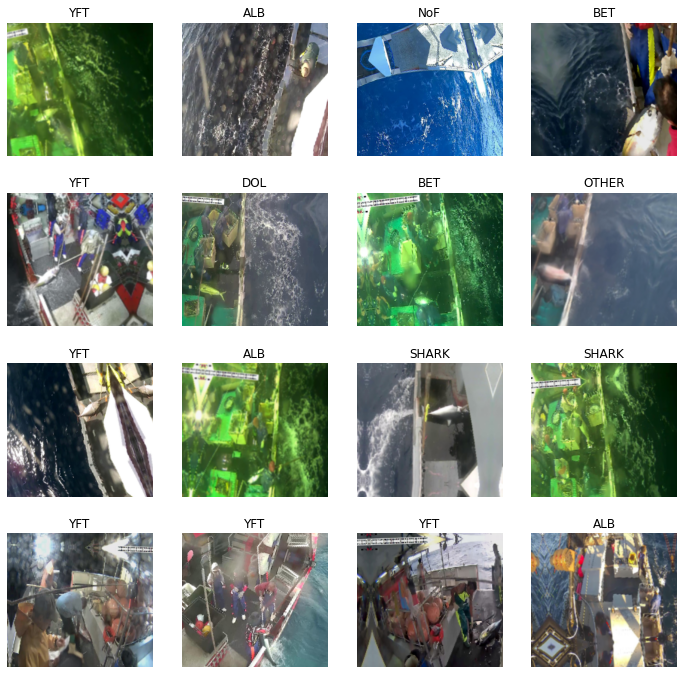

In [13]:
# Show a few Samples
dls.show_batch(max_n=16)

## Model Training

In [14]:
# Define Metric
# actual metric is loss, see: https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/overview/evaluation
# but we also use ROC AUC here

def comp_mean_roc_auc(preds, targs, labels=range(len(labels))):
    targs = np.eye(8)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def ALB_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[0])

def BET_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[1])

def DOL_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[2])

def LAG_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[3])

def NoF_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[4])

def OTHER_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[5])

def SHARK_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[6])

def YFT_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[7])

# Add Competition Matric and Some Other Metrics
metrics = [
    AccumMetric(comp_mean_roc_auc, flatten=False),
    AccumMetric(ALB_roc_auc, flatten=False),
    AccumMetric(BET_roc_auc, flatten=False),
    AccumMetric(DOL_roc_auc, flatten=False),
    AccumMetric(LAG_roc_auc, flatten=False),
    AccumMetric(NoF_roc_auc, flatten=False),
    AccumMetric(OTHER_roc_auc, flatten=False),
    AccumMetric(SHARK_roc_auc, flatten=False),
    AccumMetric(YFT_roc_auc, flatten=False),
    accuracy,
]

In [15]:
# Create Learner
set_seed(seed, reproducible=True)

learn = cnn_learner(
    dls, resnet50, metrics = metrics
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0010000000474974513)

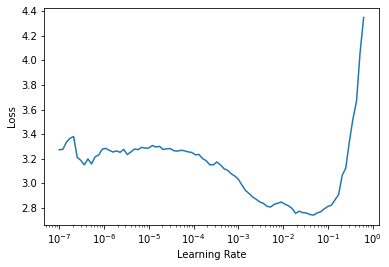

In [16]:
# Find Learning Rate
set_seed(seed, reproducible=True)

learn.lr_find()

In [17]:
# Model Training
set_seed(seed, reproducible=True)

learn.fine_tune(8, base_lr=1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,comp_mean_roc_auc,ALB_roc_auc,BET_roc_auc,DOL_roc_auc,LAG_roc_auc,NoF_roc_auc,OTHER_roc_auc,SHARK_roc_auc,YFT_roc_auc,accuracy,time
0,1.938433,1.370605,0.899120,0.879198,0.740172,0.955034,0.950645,0.975024,0.843552,0.946467,0.902867,0.575269,00:49
1,1.440718,1.008915,0.910833,0.864734,0.818291,0.963675,0.969797,0.978894,0.871404,0.967619,0.852246,0.681004,00:48
2,1.296894,0.835588,0.927022,0.843156,0.863072,0.994727,0.995948,0.975938,0.886400,0.946679,0.910254,0.756272,00:49


epoch,train_loss,valid_loss,comp_mean_roc_auc,ALB_roc_auc,BET_roc_auc,DOL_roc_auc,LAG_roc_auc,NoF_roc_auc,OTHER_roc_auc,SHARK_roc_auc,YFT_roc_auc,accuracy,time
0,0.957389,0.668264,0.956379,0.903436,0.915421,0.992676,0.994230,0.969088,0.963622,0.956338,0.956221,0.788530,01:54
1,0.886753,0.923438,0.944519,0.915339,0.822536,0.989454,0.999877,0.984687,0.950426,0.951469,0.942366,0.756272,01:53
2,0.871747,0.851983,0.938111,0.898657,0.868748,0.984328,0.991283,0.970584,0.985276,0.924383,0.881633,0.740143,01:54
3,0.660787,0.667661,0.958588,0.901832,0.882360,0.989649,0.996931,0.985518,0.980147,0.960196,0.972070,0.802867,01:53
4,0.469604,0.297521,0.979668,0.980017,0.930740,0.999609,0.999632,0.988058,0.992612,0.964719,0.981955,0.928315,01:54
5,0.285151,0.253251,0.982681,0.959644,0.957272,0.996778,1.000000,0.997555,0.995109,0.961420,0.993670,0.935484,01:53
6,0.187206,0.202707,0.986782,0.982868,0.969269,1.000000,1.000000,0.997721,0.992018,0.956205,0.996176,0.946237,01:54
7,0.144218,0.199646,0.987681,0.987631,0.970492,0.999902,1.000000,0.997697,0.993071,0.956258,0.996396,0.951613,01:54


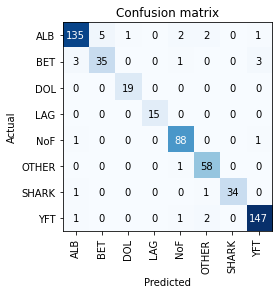

In [18]:
# Plot Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

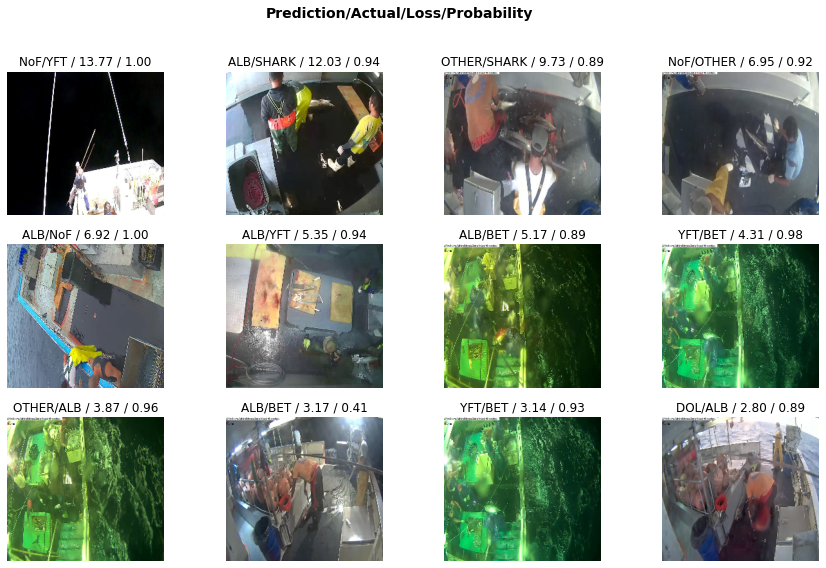

In [19]:
# Plot Top Losses
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [20]:
# Print Most Confused Classes
interp.most_confused()

[('ALB', 'BET', 5),
 ('BET', 'ALB', 3),
 ('BET', 'YFT', 3),
 ('ALB', 'NoF', 2),
 ('ALB', 'OTHER', 2),
 ('YFT', 'OTHER', 2),
 ('ALB', 'DOL', 1),
 ('ALB', 'YFT', 1),
 ('BET', 'NoF', 1),
 ('NoF', 'ALB', 1),
 ('NoF', 'YFT', 1),
 ('OTHER', 'NoF', 1),
 ('SHARK', 'ALB', 1),
 ('SHARK', 'OTHER', 1),
 ('YFT', 'ALB', 1),
 ('YFT', 'NoF', 1)]

In [21]:
# Save Model
learn.save('fm_train_df_acus_layer1_c_resnet50_s0_fastai')
torch.save(learn.model, 'fm_train_df_acus_layer1_c_resnet50_s0.pth')

## Test Set Predictions

In [22]:
!apt-get install p7zip
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Fetched 358 kB in 1s (315 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 100757 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-rar
The following NEW packages will be installed:
  p7zip-full
0 upgraded, 1 new

In [23]:
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg1.zip .
!cp /kaggle/input/the-nature-conservancy-fisheries-monitoring/test_stg2.7z .
!unzip test_stg1.zip
!mv test_stg1/* train
!mkdir train/test_stg2
!7z e test_stg2.7z -otrain/test_stg2
!rm -rf test_stg1

Archive:  test_stg1.zip
   creating: test_stg1/
  inflating: test_stg1/img_00005.jpg  
  inflating: test_stg1/img_00007.jpg  
  inflating: test_stg1/img_00009.jpg  
  inflating: test_stg1/img_00018.jpg  
  inflating: test_stg1/img_00027.jpg  
  inflating: test_stg1/img_00030.jpg  
  inflating: test_stg1/img_00040.jpg  
  inflating: test_stg1/img_00046.jpg  
  inflating: test_stg1/img_00053.jpg  
  inflating: test_stg1/img_00071.jpg  
  inflating: test_stg1/img_00075.jpg  
  inflating: test_stg1/img_00102.jpg  
  inflating: test_stg1/img_00103.jpg  
  inflating: test_stg1/img_00109.jpg  
  inflating: test_stg1/img_00119.jpg  
  inflating: test_stg1/img_00120.jpg  
  inflating: test_stg1/img_00125.jpg  
  inflating: test_stg1/img_00128.jpg  
  inflating: test_stg1/img_00129.jpg  
  inflating: test_stg1/img_00133.jpg  
  inflating: test_stg1/img_00138.jpg  
  inflating: test_stg1/img_00141.jpg  
  inflating: test_stg1/img_00152.jpg  
  inflating: test_stg1/img_00161.jpg  
  inflating: tes

In [24]:
# Create Predictions of Testset
test_df = pd.read_csv('/kaggle/input/the-nature-conservancy-fisheries-monitoring/sample_submission_stg2.csv.zip')[['image']]
test_dl = dls.test_dl(test_df)

test_preds, _ = learn.get_preds(dl=test_dl)

In [25]:
# Create Submission DataFrame
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1); sub_df

,image,NoF,YFT,OTHER,ALB,BET,DOL,LAG,SHARK
0,img_00005.jpg,0.000942,0.000014,0.000007,3.032257e-07,0.999025,0.000004,0.000001,0.000007
1,img_00007.jpg,0.031755,0.102707,0.000377,2.102037e-05,0.000039,0.003252,0.000215,0.861634
2,img_00009.jpg,0.443261,0.512187,0.000648,7.333449e-04,0.000181,0.016004,0.000261,0.026724
3,img_00018.jpg,0.554226,0.014306,0.001198,1.816424e-03,0.003498,0.261798,0.000285,0.162872
4,img_00027.jpg,0.990666,0.000885,0.000002,3.522805e-06,0.005337,0.002339,0.000002,0.000765
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_12149.jpg,0.364046,0.244409,0.001739,6.705926e-04,0.030242,0.032422,0.000778,0.325692
13149,test_stg2/image_12150.jpg,0.209462,0.111353,0.001644,4.502127e-04,0.609661,0.002453,0.000719,0.064258
13150,test_stg2/image_12151.jpg,0.028569,0.005808,0.000384,8.360408e-05,0.003912,0.005661,0.000223,0.955359
13151,test_stg2/image_12152.jpg,0.009850,0.002043,0.000014,3.125764e-05,0.944745,0.000477,0.000181,0.042660


In [26]:
# Save Submission DataFrame 
sub_df.to_csv('sub_fm_train_df_acus_layer1_c_resnet50_s0.csv', index=False)